# Water Level Sensor Analysis
The purpose of this notebook is to import data from a custom water level sensor as well as a nearby established water level sensor to visually and quantitatively compare results

## Analysis
### Import Data
Step 1: import necessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Step 2: read in data
- there are three data files: one for each reference station (CORMP and CORMP_WL) and one for our sensor
- read these in one at a time and look at first few rows

### Start with CORMP data from CMS Dock
- https://cormp.org/?platform=CMSDOCK
- Data were downloaded using web interface and saved to CSV file named 'CORMP-CMSDOCK.csv'

In [2]:
df_cormp_cmsdock = pd.read_csv('CORMP-CMSDOCK.csv', parse_dates = [[2, 1]])

# Rename columns for easier interpretation
df_cormp_cmsdock.columns = ['Date-Time', 'Water Level (ft)']

# Add a column of water level in m for use of scientific units
df_cormp_cmsdock.loc[:, 'Water Level (m)'] = df_cormp_cmsdock.loc[:, 'Water Level (ft)']/3.28084

# Check out CORMP data
df_cormp_cmsdock.head()

,Date-Time,Water Level (ft),Water Level (m)
0,2022-06-21 10:30:00,-1.60,-0.487680
1,2022-06-21 10:36:00,-1.52,-0.463296
2,2022-06-21 10:42:00,-1.53,-0.466344
3,2022-06-21 10:48:00,-1.35,-0.411480
4,2022-06-21 10:54:00,-1.27,-0.387096


### Pull in second CORMP dataset from CMS Dock
- https://cormp.org/?platform=CMSDOCK_WL
- Secondary sensor: Green Stream
- Data were downloaded using web interface and saved to CSV file named 'CORMP-CMSDOCK_WL.csv'

In [3]:
# The path to the file will have to be modified if this notebook and the data are not in the same directory. 
# For now, easiest to keep everything in one place
df_cormp_cmsdock_wl = pd.read_csv('CORMP-CMSDOCK_WL.csv', parse_dates = [[2, 1]])

# Rename columns for easier interpretation
df_cormp_cmsdock_wl.columns = ['Date-Time', 'Water Level (ft)']

# Add a column of water level in m for use of scientific units
df_cormp_cmsdock_wl.loc[:, 'Water Level (m)'] = df_cormp_cmsdock_wl.loc[:, 'Water Level (ft)']/3.28084

# Check out CORMP data
df_cormp_cmsdock_wl.head()

,Date-Time,Water Level (ft),Water Level (m)
0,2022-06-21 10:30:00,-1.57,-0.478536
1,2022-06-21 10:36:00,-1.50,-0.457200
2,2022-06-21 10:42:00,-1.43,-0.435864
3,2022-06-21 10:48:00,-1.37,-0.417576
4,2022-06-21 10:54:00,-1.30,-0.396240


### Custom water level sensor

In [4]:
# Read in custom water level sensor data
df_coast = pd.read_csv('full_trial_test_data_raw.csv', parse_dates = [1])

# Rename columns for easier interpretation
df_coast.columns = ['Distance (in)', 'Date-Time']

# Check out custom sensor data
df_coast.head()

,Distance (in),Date-Time
0,74.51,2022-06-21 10:29:00
1,73.68,2022-06-21 10:35:00
2,73.60,2022-06-21 10:41:00
3,72.08,2022-06-21 10:47:00
4,71.32,2022-06-21 10:53:00


### Convert from distance from sensor to water to water level
Equation 1  
H = a-x  
H is water level; a is offset (determined through comparison with CORMP); x is distance measured by sensor

In [5]:
# The offset is determined through comparison with CORMP data, intended to minimize anomaly
offset_ft = 4.65

# Calculate water level in feet first using offset above
df_coast.loc[:, 'Water Level (ft)'] = offset_ft-df_coast.loc[:, 'Distance (in)']/12

# Add a column of water level in m for use of scientific units
df_coast.loc[:, 'Water Level (m)'] = df_coast.loc[:, 'Water Level (ft)']/3.28084

# Check out converted custom sensor data
df_coast.head()

,Distance (in),Date-Time,Water Level (ft),Water Level (m)
0,74.51,2022-06-21 10:29:00,-1.559167,-0.475234
1,73.68,2022-06-21 10:35:00,-1.490000,-0.454152
2,73.60,2022-06-21 10:41:00,-1.483333,-0.452120
3,72.08,2022-06-21 10:47:00,-1.356667,-0.413512
4,71.32,2022-06-21 10:53:00,-1.293333,-0.394208


### Interpolate to put on same timestamps and compare

In [6]:
coast_on_cormp_cmsdock_time = np.interp(df_cormp_cmsdock.loc[:, 'Date-Time'], # new timestamp
                                        df_coast.loc[:, 'Date-Time'],         # old timestamp
                                        df_coast.loc[:, 'Water Level (m)'],   # old data
                                        left = np.nan, right = np.nan)

coast_minus_cmsdock_anomaly = coast_on_cormp_cmsdock_time-df_cormp_cmsdock.loc[:, 'Water Level (m)']

rmse_coast_cmsdock = np.sqrt(np.sum((coast_minus_cmsdock_anomaly)**2)/(len(coast_minus_cmsdock_anomaly)))

print(np.nanmean(coast_minus_cmsdock_anomaly), np.nanstd(coast_minus_cmsdock_anomaly), rmse_coast_cmsdock)

-0.00013850196194360384 0.01447602295617409 0.014473702166433738


### Plot
Add time-series plot(s) of water level from both sensors

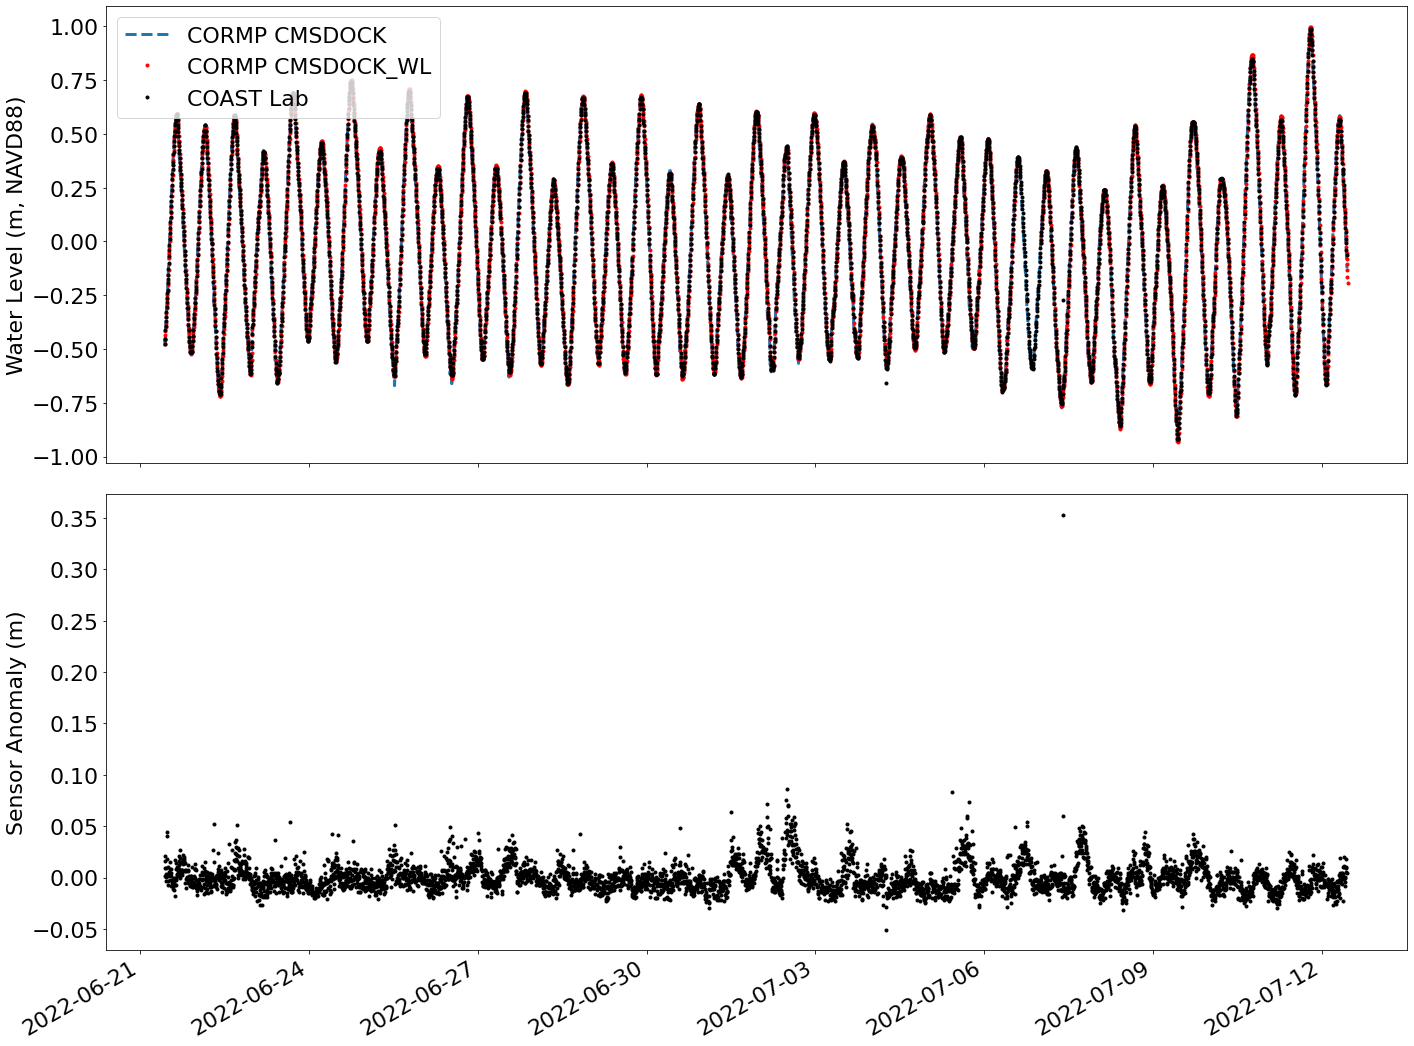

In [7]:
# Create figure
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(figsize=(20, 15), nrows = 2, sharex = True)

# Plot CORMP CMSDOCK data
axs[0].plot(df_cormp_cmsdock.loc[:, 'Date-Time'], df_cormp_cmsdock.loc[:, 'Water Level (m)'], '--', label="CORMP CMSDOCK", linewidth=3)

# Plot CORMP CMSDOCK_WL data (Green Stream)
axs[0].plot(df_cormp_cmsdock_wl.loc[:, 'Date-Time'], df_cormp_cmsdock_wl.loc[:, 'Water Level (m)'], 'r.', label="CORMP CMSDOCK_WL", linewidth=3)

# Plot custom water level sensor data
axs[0].plot(df_coast.loc[:, 'Date-Time'], df_coast.loc[:, 'Water Level (m)'], 'k.', label="COAST Lab", linewidth=3)

# Format plot elements
axs[0].legend(loc="upper left")
axs[0].set_ylabel('Water Level (m, NAVD88)')

# Add anomaly plot
axs[1].plot(df_cormp_cmsdock.loc[:, 'Date-Time'], coast_minus_cmsdock_anomaly, 'k.', linewidth = 3)
axs[1].set_ylabel('Sensor Anomaly (m)')

axs[0].set_xlabel('Date/Time')
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=3))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('water_level.png', dpi = 600)

### Calculate root mean squared error
- Compare custom sensor to CMSDOCK sensor